In [12]:
from utils.vgg16 import *
import os
import pickle
import lasagne
import urllib
import numpy as np
import io
import skimage.transform
import matplotlib.pyplot as plt
from lasagne.utils import floatX
%matplotlib inline

In [2]:
if not os.path.exists('vgg16.pkl'):
  !wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

In [3]:
model_weights_path = 'vgg16.pkl'
net = build_model()
output_layer = net['prob']

In [4]:
model = pickle.load(open(model_weights_path))
CLASSES = model['synset words']
print net.keys()
lasagne.layers.set_all_param_values(output_layer, model['param values'])

['fc6', 'fc7', 'fc8', 'conv1_1', 'conv1_2', 'conv5_1', 'conv5_3', 'conv5_2', 'conv4_1', 'conv4_2', 'conv4_3', 'conv3_3', 'conv3_2', 'fc6_dropout', 'pool3', 'pool2', 'pool1', 'conv2_2', 'prob', 'pool5', 'pool4', 'conv3_1', 'input', 'fc7_dropout', 'conv2_1']


In [5]:
index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(23)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

In [6]:
MEAN_IMAGE = np.reshape(model['mean value'], (3,1,1))

In [7]:
def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

In [8]:
print image_urls

['http://farm1.static.flickr.com/8/11912062_a1dda4fa83.jpg', 'http://farm4.static.flickr.com/3649/3320711239_0663522aca.jpg', 'http://farm4.static.flickr.com/3057/2975067450_98bec812af.jpg', 'http://farm3.static.flickr.com/2452/3932323110_833174f459.jpg', 'http://www.tmk.com/tiger/6F5S5684-l.jpg']


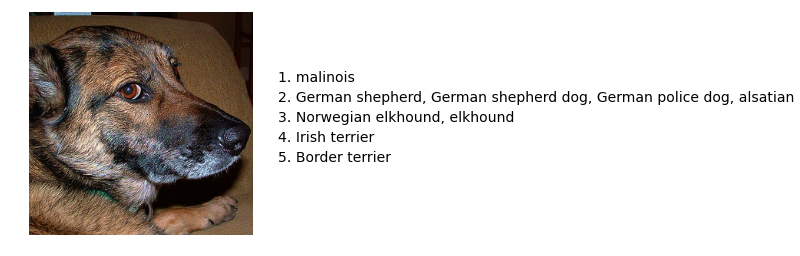

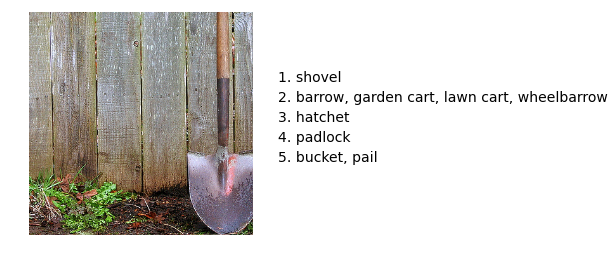

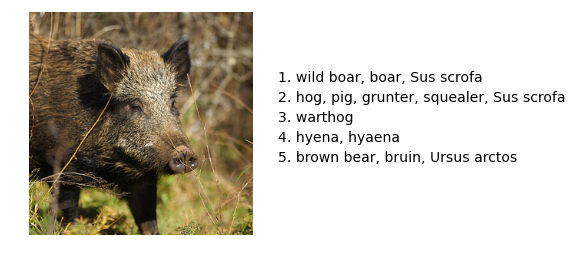

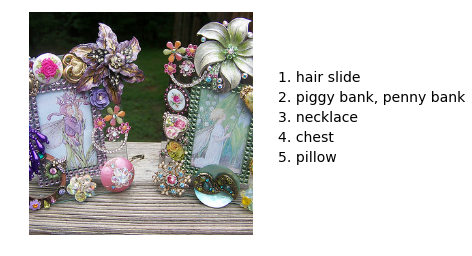

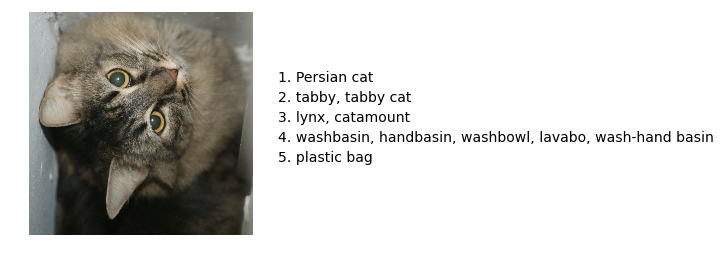

In [13]:
for url in image_urls:
  try:
      rawim, im = prep_image(url)

      prob = np.array(lasagne.layers.get_output(output_layer, im, deterministic=True).eval())
      top5 = np.argsort(prob[0])[-1:-6:-1]
      plt.figure()
      plt.imshow(rawim.astype('uint8'))
      plt.axis('off')
      for n, label in enumerate(top5):
          plt.text(250, 70 + n * 20, '{}. {}'.format(n+1, CLASSES[label]), fontsize=14)
  except IOError:
      print('bad url: ' + url)